In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
%matplotlib inline

In [2]:
# Read csv file, convert time to datetime data type, create persistance model
df = pd.read_csv("flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
df['crawford_pers_forecast'] = df['crawfordCrescent_F2'].shift(336, axis=0)
pers = df["crawford_pers_forecast"].iloc[336:].values

In [7]:
# Limit where battery charge will toggle
trigger = 12
battChargeInst = 0
battCharge = []
loadInst = 0
load = []
# Capacity of battery, look into this more later
battCapacity = 50
# diff > 0 charging, diff < 0 discharing
diff = 12 - pers
for index, value in enumerate(diff):
    if value >= 0:
        # If the battery is charging, check if it's full
        if battChargeInst < battCapacity:
            # If its full increase the charge by the difference between load and trigger
            battChargeInst += value
            # Avoid battery charge going over the maximum
            if battChargeInst > battCapacity:
                battChargeInst = battCapacity
            battCharge.append(battChargeInst)
            # Load at that moment will be the trigger value
            load.append(trigger)
        # If battery is full, the load will only be the value from the forecast
        else:
            load.append(pers[index])
            battCharge.append(battChargeInst)
    else:
        # If battery is discharging, check it isn't empty
        if battChargeInst > 0:
            # If not empty, take charge from battery
            battChargeInst += value
            if battChargeInst < 0:
                battChargeInst = 0
            battCharge.append(battChargeInst)
            load.append(trigger)
        else:
            load.append(pers[index])
            battCharge.append(battChargeInst)




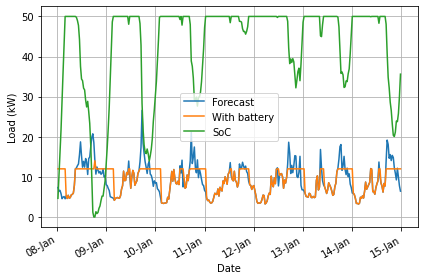

In [8]:
l = 0
h = 335

fig, ax = plt.subplots()
ax.plot(df["Timestamp"].iloc[l+336:h+336], pers[l:h], label="Forecast")
ax.plot(df["Timestamp"].iloc[l+336:h+336], load[l:h], label="With battery")
ax.plot(df["Timestamp"].iloc[l+336:h+336], battCharge[l:h], label="SoC")
# Major ticks every day
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.grid(True)
# Set labels to day number - month name
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
# Rotates and right-aligns the x labels to avoid crowding
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel("Load (kW)")
ax.set_xlabel("Date")
ax.legend()

plt.tight_layout()
#plt.savefig("pers_forecast.jpg", dpi=300, bbox_inches="tight")
plt.show()